# DDPG Main

## Data Preprocessing

In [83]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import random
from collections import deque
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import numpy as np
import gymnasium
from gymnasium import spaces


# Load data
#C:\Users\rohit\OneDrive\Documents\Asset-Pricing-with-Reinforcement-Learning\XOM_30_minute_6_month_data.csv
df = pd.read_csv('XOM_30_minute_6_month_data.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True)

# Normalize
scaler = MinMaxScaler()
df[['Last Price', 'Volume', 'SMAVG (15)']] = scaler.fit_transform(df[['Last Price', 'Volume', 'SMAVG (15)']])

# Split into training and testing sets
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

print(train_df[10:])

                    Date  Last Price    Volume  SMAVG (15)
2331 2023-03-07 20:00:00    0.596608  0.049707    0.072420
2330 2023-03-07 20:30:00    0.606681  0.165330    0.086878
2329 2023-03-08 14:30:00    0.634154  0.134774    0.099523
2328 2023-03-08 15:00:00    0.608055  0.086473    0.077523
2327 2023-03-08 15:30:00    0.571654  0.099766    0.067301
...                  ...         ...       ...         ...
473  2023-09-29 20:30:00    0.881409  0.306496    0.180971
472  2023-10-02 14:30:00    0.794870  0.171930    0.194260
471  2023-10-02 15:00:00    0.755034  0.144825    0.184963
470  2023-10-02 15:30:00    0.762818  0.113712    0.166506
469  2023-10-02 16:00:00    0.764192  0.092697    0.157100

[1863 rows x 4 columns]


## Environment

In [84]:
class DDPGTradingEnv(gymnasium.Env):

  def __init__(self, df):
    super().__init__()
    
    self.df = df
    self.current_step = 0
    self.total_steps = 500 #len(df) - 1

    # Negatives mean quantity to sell, 0 is hold, positives mean buy
    self.action_space = spaces.Box(low=-1, high=1, shape=(1, ), dtype=np.float32)
    # Observation space: normalized last price, normalized shares held, normalized cash balance
    self.observation_space = spaces.Box(low=0, high=1, shape=(3,), dtype=np.float32)

    self.reset()

  def reset(self):
    self.current_step = 0
    self.total_profit = 0
    self.cash_balance = 10000
    self.shares_held = 0
    self.portfolio_value = self.cash_balance

    self.previous_portfolio_value = self.portfolio_value
    # For plotting
    self.portfolio_history = [self.portfolio_value]

    return self.get_observation()

  def get_observation(self):
    current_price = self.df.loc[self.current_step, 'Last Price']
    return np.array([float(current_price), float(self.shares_held), float(self.cash_balance)])

  # Action space is one number between -1 and 1.
  def take_action(self, action_value):
    current_price = self.df.loc[self.current_step, 'Last Price']
    if action_value > 0:
      self.buy_stock(action_value, current_price)
    elif action_value < 0:
      self.sell_stock(action_value, current_price)
    # Update the portfolio value
    self.previous_portfolio_value = self.portfolio_value
    self.portfolio_value = self.cash_balance + (self.shares_held * current_price)

  def buy_stock(self, num_stocks, current_price):
    self.cash_balance -= (num_stocks * current_price)
    self.shares_held += num_stocks

  def sell_stock(self, num_stocks, current_price):
    self.cash_balance += (num_stocks * current_price)
    self.shares_held -= num_stocks

  def step(self, action):
    self.current_step += 1
    self.take_action(action)
    reward = self.calculate_reward()
    terminated = (self.current_step >= self.total_steps)
    observation = self.get_observation()
    info = {'current_step': self.current_step, 'portfolio_value': self.portfolio_value}
    self.portfolio_history.append(self.portfolio_value)
    return observation, reward, terminated, info

  def render(self, mode='human'):
    if mode == 'human':
      print(f"Step: {self.current_step}, Portfolio Value: {self.portfolio_value}")

  # The reward is the change in portfolio value the next time_step
  def calculate_reward(self):
    reward = self.portfolio_value - self.previous_portfolio_value
    return reward

## DDPG Classes

## Actor & Critic Class

In [85]:
# Input: Current state
# Output: Action to be taken
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=128):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        return x
    
# Input: Current State & Actor's action
# Output: Expected value of state-action pair
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=128):
        super(Critic, self).__init__()
        self.fc1_state = nn.Linear(state_dim, 64)
        self.fc2_state = nn.Linear(64, 64)
        self.fc2_action = nn.Linear(action_dim, 64)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, state, action):
        x_state = F.relu(self.fc1_state(state))
        x_state = F.relu(self.fc2_state(x_state))

        x_action = F.relu(self.fc2_action(action))

        x = torch.cat((x_state, x_action), dim=0)
        x = F.relu(x)
        x = self.fc3(x)
        return x

In [86]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Because DDPG is an off-policy actor-critic policy-gradient algorithm, this means that the critic
# evaluates the actor, but because they are off-policy, the agents act according to their own
# policy but learn according to the target policy.

# Initialise environment:
env = DDPGTradingEnv(df)

# Pseudocode line 1:
# Initialize replay memory 𝐷 to capacity 𝑁
N = 1000
replay_memory = []
# replay_memory = deque(maxlen=N)
# Initialise minibatch size
minibatch_size = 50
    
# Pseudocode line 2 & 3:
# Initialize actor network 𝜋̂ 1 with parameters 𝒘1 arbitrarily
# Initialize target actor network 𝜋̂ 2 with parameters 𝒘2=𝒘1
state_dim = 3
action_dim = 1
actor_model = Actor(state_dim, action_dim)
target_actor_model = Actor(state_dim, action_dim)

# Pseudocode line 4 & 5:
# Initialize critic network 𝑞̂ 1 with parameters 𝜽1 arbitrarily
# Initialize target critic network 𝑞̂ 2 with parameters 𝜽2=𝜽1
critic_model = Critic(state_dim, action_dim)
target_critic_model = Critic(state_dim, action_dim)

# Pseudocode line 6: Algorithm parameters: target network learning rate 𝛽>0
beta = 0.005
# Gamma is the discount factor (importance of future rewards)
gamma = 0.9

# This is for the gradient descent, we will probably put this in a learn method in the DDPG class
lr = 0.005
optimizer_critic = optim.Adam(critic_model.parameters(), lr=lr)
optimizer_actor = optim.Adam(actor_model.parameters(), lr=lr)

# Loop for each episode:
num_episodes = 1
for i in range(num_episodes):
    # Initialise random process ϵ for action exploration
    epsilon = 0.1
    # Initialise S
    state = env.reset()

    # Loop for each step of episode (each time step in df)
    terminated = False
    while not terminated:
        # Select action 𝐴←𝜋̂ 1(𝑆,𝒘1)+
        action = actor_model(torch.FloatTensor(state).to(device))
        action = action.detach().to('cpu').numpy()
        # Add exploration noise (optional)
        action += epsilon * np.random.randn(action_dim)
        # Execute action 𝐴, observe reward 𝑅 and next-state 𝑆′
        new_state, reward, terminated, info = env.step(action)
        # Store transition (𝑆,𝐴,𝑅,𝑆′) in 𝐷
        # transition = (state, action, reward, new_state)
        transition = (torch.FloatTensor(state), torch.FloatTensor(action), torch.FloatTensor(reward), torch.FloatTensor(new_state.astype(np.float64)))
        replay_memory.append(transition)
        # For each transition (𝑆𝑗,𝐴𝑗,𝑅𝑗,𝑆′𝑗) in minibatch sampled from 𝐷:
        if len(replay_memory) <= minibatch_size:
            minibatch_sampled_from_D = replay_memory
        else:
            minibatch_sampled_from_D = random.sample(replay_memory, minibatch_size)
        for transition in minibatch_sampled_from_D:
            # 𝑦←𝑅𝑗+𝛾𝑞̂ 2(𝑆′𝑗,𝜋̂ 2(𝑆′𝑗,𝒘2),𝜽2)
            state, action, reward, new_state = transition

            # Makes sure state and action are on same device
            state = state.to(device)
            action = action.to(device)
            new_state_tensor = torch.FloatTensor(new_state).to(device)

            # 𝜋̂ 2(𝑆′𝑗,𝒘2)
            target_actor_output = target_actor_model(new_state_tensor)
            # y is the TD target value (improved Q-value)
            y = reward + gamma * target_critic_model(new_state_tensor, target_actor_output)
            
            # Perform gradient descent step ∇𝜽1(𝑦−𝑞̂ 1(𝑆𝑗,𝐴𝑗,𝜽1))2 for critic (critic learning from target critic)
            critic_output = critic_model(state, action)
            # critic_loss = F.mse_loss(critic_output, y)
            # y.detach removes tensor
            critic_loss = nn.MSELoss().to(device)(critic_output, y.detach())
            optimizer_critic.zero_grad()
            critic_loss.backward()
            optimizer_critic.step()
            # Perform gradient ascent step ∇𝑤1𝐸[𝑞̂ 1(𝑆𝑗,𝜋̂ 1(𝑆𝑗,𝒘1),𝜽1)] for actor (actor learning from critic)
            actor_output = actor_model(state)
            actor_loss = -torch.mean(critic_model(state, actor_output))
            optimizer_actor.zero_grad()
            actor_loss.backward()
            optimizer_actor.step()
        # Update target actor network parameters 𝒘2←𝛽𝒘1+(1−𝛽)𝒘2
        for target_param, param in zip(target_actor_model.parameters(), actor_model.parameters()):
            target_param.data.copy_(beta * param.data + (1 - beta) * target_param.data)    
        # Update target critic network parameters 𝜽2←𝛽𝜽1+(1−𝛽)𝜽2
        for target_param, param in zip(target_critic_model.parameters(), critic_model.parameters()):
            target_param.data.copy_(beta * param.data + (1 - beta) * target_param.data)

        # Update state
        state = new_state


[1000, array([1000.], dtype=float32), array([1000.0067], dtype=float32), array([999.9442], dtype=float32), array([999.9194], dtype=float32), array([1000.08606], dtype=float32), array([1000.19073], dtype=float32), array([1000.17395], dtype=float32), array([1000.1522], dtype=float32), array([1000.22754], dtype=float32), array([1000.19415], dtype=float32), array([1000.1574], dtype=float32), array([1000.18787], dtype=float32), array([1000.2431], dtype=float32), array([1000.15533], dtype=float32), array([1000.23694], dtype=float32), array([1000.61053], dtype=float32), array([1000.5695], dtype=float32), array([1000.14404], dtype=float32), array([1000.37], dtype=float32), array([1000.3524], dtype=float32), array([1000.2836], dtype=float32), array([1000.5223], dtype=float32), array([1000.2868], dtype=float32), array([1000.0933], dtype=float32), array([999.9367], dtype=float32), array([999.4806], dtype=float32), array([999.2189], dtype=float32), array([998.91986], dtype=float32), array([998.520

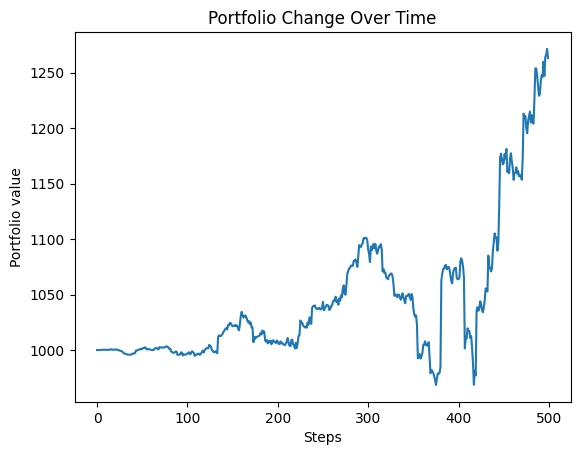

In [87]:
import matplotlib.pyplot as plt

plt.plot(env.portfolio_history[1:])
print(env.portfolio_history)
plt.title("Portfolio Change Over Time")
plt.xlabel("Steps")
plt.ylabel("Portfolio value")
plt.show()